# Multirate Sampling

In [1]:
# Modules
import warnings
import numpy as np
from scipy.signal import decimate
from operator import itemgetter

In [2]:
# Modules
import h5py
import math
import warnings
import numpy as np
from scipy.signal import decimate
from operator import itemgetter

# Plotting
import matplotlib
import matplotlib.pyplot as plt
# Font and plot parameters
# plt.rcParams.update({'font.size': 22})

### Common Functions

In [28]:
def prime_factors(n):
    # Return the prime factors, to be used in decimation
    i = 2
    factors = []
    while i**2<=n:
        if n%i:
            i+=1
        else:
            n//=i
            factors.append(i)
    if n>1:
        factors.append(n)
    return factors

In [29]:
def velocity_to_frequency(v, M):
    """ Calculate the gravitational-wave frequency from the
    total mass and invariant velocity.
    Taken from:
        https://pycbc.org/pycbc/latest/html/_modules/pycbc/conversions.html

    Parameters
    ----------
    v : float
        Invariant velocity
    M : float
        Binary total mass

    Returns
    -------
    f : float
        Gravitational-wave frequency
    """
    MTSUN_SI = 4.92549102554e-06
    return v**(3.0) / (M * MTSUN_SI * np.pi)

In [30]:
def f_schwarzchild_isco(M):
    """
    Innermost stable circular orbit (ISCO) for a test particle
    orbiting a Schwarzschild black hole.
    Taken from:
        https://pycbc.org/pycbc/latest/html/_modules/pycbc/conversions.html

    Parameters
    ----------
    M : float or numpy.array
        Total mass in solar mass units

    Returns
    -------
    f : float or numpy.array
        Frequency in Hz
    """
    return velocity_to_frequency((1.0/6.0)**(0.5), M)

### Check Frequency Evolution of GW using priors

In [31]:
import matplotlib.pyplot as pp
from matplotlib import cm
from pycbc import waveform
from pycbc import pnutils

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lalsimulation as lalsim

In [32]:
imr_chirp_time = lambda m1, m2, s1z, s2z, fl: lalsim.SimIMRPhenomDChirpTime(m1*1.989e+30, m2*1.989e+30, s1z, s2z, fl)

In [33]:
imr_chirp_time(7., 7., 0.99, 0.99, 20.)

11.580419884200776

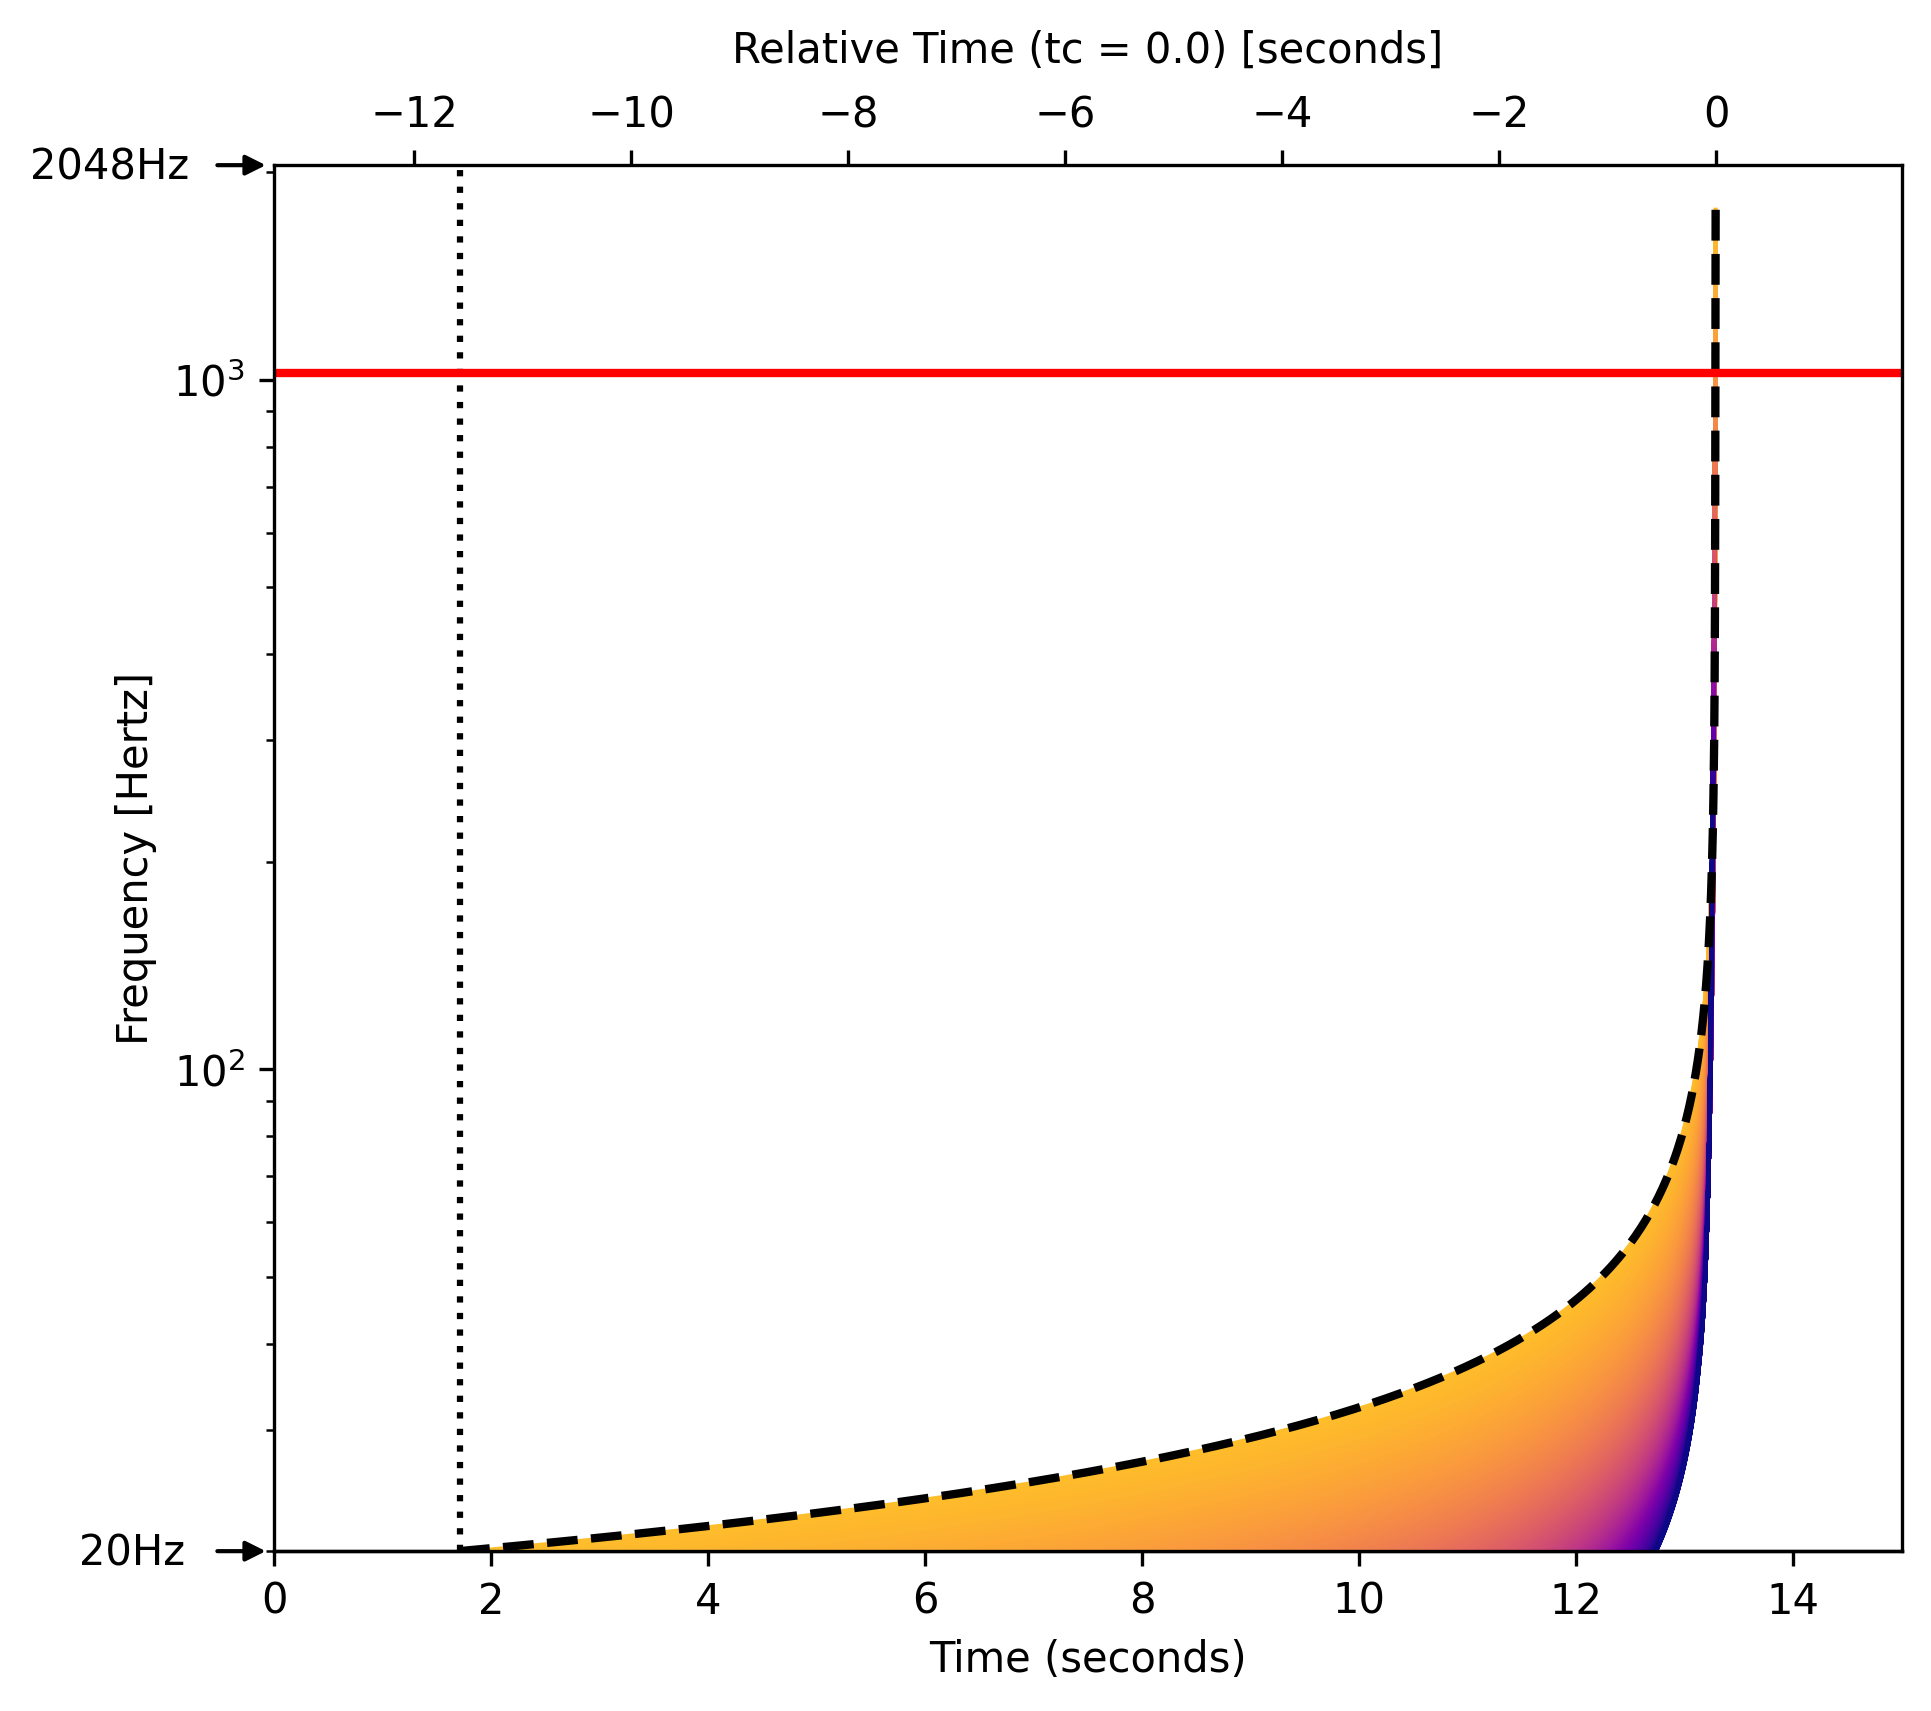

In [34]:
mass1 = 50.0
mass2 = 50.0
eta = mass1*mass2 / (mass1 + mass2)**2.
max_mchirp = eta**(3./5) * (mass1 + mass2)

fig, ax = pp.subplots(figsize=(7.0, 6.0), dpi=300)

for mass1 in np.linspace(7.1, 50.0, 1024):
    mass2 = mass1 - 0.1
    assert mass1 > mass2

    t, f = pnutils.get_inspiral_tf(tc=0.0, mass1=mass1, mass2=mass2, 
                                   spin1=0.99, spin2=0.99, 
                                   f_low=20.0, n_points=512, 
                                   pn_2order=7, 
                                   approximant='IMRPhenomD')

    eta = mass1*mass2 / (mass1 + mass2)**2.
    mchirp = eta**(3./5) * (mass1 + mass2)/max_mchirp
    # ax.plot(t, f, linewidth=1.0, c=cm.OrRd(mchirp))
    ax.plot(t, f, linewidth=1.0, c=cm.plasma_r(mchirp))

# Longest waveform in prior
M = 14.0 # total lowest mass in prior
f_ISCO_highest = f_schwarzchild_isco(M)
t_highest, f_highest = pnutils.get_inspiral_tf(tc=0.0, mass1=7., mass2=7., 
                               spin1=0.99, spin2=0.99, 
                               f_low=20.0, n_points=512, 
                               pn_2order=7, 
                               approximant='IMRPhenomD')

# Plotting
ax.plot(t_highest, f_highest, linestyle='dashed', linewidth=2.0, color='k')
# ax.plot(t_highest, f_highest*2., linestyle='dashdot', linewidth=1.5, color='k')
ax.axvline(-imr_chirp_time(7., 7., 0.99, 0.99, 20.), color='k', linestyle='dotted')
ax.axhline(1024.0, color='red', linestyle='solid', linewidth=2.0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

## Add arrows to specific points on y-axis
# Low-frequency cutoff
ax.annotate('', xy=(0, 0), xycoords='axes fraction', textcoords='axes fraction',
            xytext=(-0.04, 0), arrowprops=dict(arrowstyle="-|>", color='k'))
ax.annotate('20Hz', xy=(-0.12, -0.01), xycoords='axes fraction')
# Maximum sampling rate
ax.annotate('', xy=(0, 1), xycoords='axes fraction', textcoords='axes fraction',
            xytext=(-0.04, 1), arrowprops=dict(arrowstyle="-|>", color='k'))
ax.annotate('2048Hz', xy=(-0.15, 0.99), xycoords='axes fraction')

# Padding
pad = 15.0 - imr_chirp_time(7., 7., 0.99, 0.99, 20.)
lpad = pad/2.
rpad = pad - lpad
tc = 15.0 - rpad

# Create secondary x-axis
x_to_altx = lambda x: x + tc
altx_to_x = lambda altx: altx - tc
secax = ax.secondary_xaxis('bottom', functions=(x_to_altx, altx_to_x))
secax.set_xlabel('Time (seconds)')

ax.set_ylabel('Frequency [Hertz]')
ax.set_xlabel('Relative Time (tc = 0.0) [seconds]', labelpad=7.5)
ax.set_ylim(20.0, 2048.)
ax.set_yscale('log')
ax.set_xlim(-imr_chirp_time(7., 7., 0.99, 0.99, 20.)-lpad, rpad)
pp.savefig("./paper/multirate_sampling_template.png")
pp.show()

Missing features: colorbar, legend, altered nyquist limit, upper limit on location of waveform.

In [35]:
freq = f_ISCO_highest # Hz
idx = (np.abs(f_highest - freq)).argmin()
time_at_300Hz = -t_highest[idx]
print(time_at_300Hz)

0.01661841904343987


### Multirate sampling fixed parameters

In [36]:
from pycbc.conversions import tau_from_final_mass_spin, get_final_from_initial
from pycbc.detector import Detector

In [37]:
def get_time_at_freq(t, f, search_freq):
    idx = (np.abs(f - search_freq)).argmin()
    time_at_search_freq = -t[idx]
    return time_at_search_freq

def get_freq_at_time(t, f, search_time):
    t = -t
    idx = (np.abs(t - search_time)).argmin()
    freq_at_search_time = f[idx]
    return freq_at_search_time

In [38]:
def get_tf_evolution_before_tc(prior_low_mass, signal_low_freq_cutoff, sample_rate):
    # Get npoints from tau
    npoints = imr_chirp_time(prior_low_mass, prior_low_mass, 
                             0.99, 0.99, 
                             signal_low_freq_cutoff) * sample_rate
    # Get tf of given waveform
    t, f = pnutils.get_inspiral_tf(tc=0.0, 
                        mass1=prior_low_mass, mass2=prior_low_mass, 
                        spin1=0.99, spin2=0.99, 
                        f_low=signal_low_freq_cutoff, 
                        n_points=int(npoints), 
                        pn_2order=7, 
                        approximant='IMRPhenomD')
    return (t, f)

In [39]:
# Example
t, f = get_tf_evolution_before_tc(7.0, 20.0, 2048.0)
len_2048 = 826 # 300 Hz to end
len_ds1 = (26822 - int((13.147 - 0.03 - get_time_at_freq(t, f, 150.0)) * 2048.)) # 150 Hz to 300 Hz
len_ds2 = (int((13.147 - 0.03 - get_time_at_freq(t, f, 150.0)) * 2048.) - int((13.147 - 0.03 - get_time_at_freq(t, f, 75.0)) * 2048.)) # 75 Hz to 150 Hz
len_ds3 = (int((13.147 - 0.03 - get_time_at_freq(t, f, 75.0)) * 2048.)) # 20 Hz to 75 Hz
len_ds_noise = (int(12.0 * 2048.) - (len_2048 + len_ds1 + len_ds2 + len_ds3)) # noise 

len_ds1 /= (2048./620.)
len_ds2 /= (2048./320.)
len_ds3 /= (2048./200.)
len_ds_noise /= (2048./200.)
print('Final length = {} samples'.format(len_2048+len_ds1+len_ds2+len_ds3+len_ds_noise))

Final length = 3202.552734375 samples


In [40]:
def get_sampling_rate_bins():
    
    """ Params """
    # Get data_cfg input params
    signal_low_freq_cutoff = 20.0
    sample_rate = 2048.
    prior_low_mass = 7.0
    prior_high_mass = 50.0
    signal_length = 12.0

    decimation_start_freq = 250 # Hz
    noise_pad = 1.5 # seconds
    num_blocks = 5
    lowest_allowed_fs = 225 # Hz
    gap_bw_nyquist_and_fs = 42 # Hz
    override_freqs = [20] + [30, 50, 100, 150] + [decimation_start_freq]

    split_with_freqs = False
    split_with_times = True
    
    """ Post Fudge Factor """
    # Get fudge factor that accounts for wrap around from PyCBC
    # This can be used to estimate the merger+ringdown leeway for MR sampling
    # This should account for waveform content after tc
    m_final, spin_final = get_final_from_initial(mass1=prior_high_mass, 
                                                 mass2=prior_high_mass, 
                                                 spin1z=0.99, spin2z=0.99)
    post_fudge_factor = tau_from_final_mass_spin(m_final, spin_final) * 10 * 1.5 # just in case
    # Adding light travel time between detectors H1 and V1 (We use H1 and L1, but just in case)
    light_travel_time = Detector('H1').light_travel_time_to_detector(Detector('V1')) * 1.1
    post_fudge_factor += light_travel_time
    # Quite generously, we include the following fudge duration
    # print('Post fudge duration = {} s'.format(post_fudge_factor))
    tc_inject_lower = signal_length - (noise_pad + post_fudge_factor + 0.2)
    tc_inject_upper = tc_inject_lower + 0.2

    """ Pre Fudge Factor """
    # Calculate fudge factor at left end of the waveform injection
    # Get t, f from lowest mass binary system
    # The times should vary from 0.0 to -tau starting at tc
    t, f = get_tf_evolution_before_tc(prior_low_mass, 
                                      signal_low_freq_cutoff, 
                                      sample_rate)
    time_at_decim_start_freq = get_time_at_freq(t, f, search_freq=decimation_start_freq)
    pre_fudge_factor = (light_travel_time + time_at_decim_start_freq) * 1.1 # just in case
    # print('Pre fudge duration = {} s'.format(pre_fudge_factor))

    """ MR Sampling params """
    bins = {}
    # Noise block after ringdown
    bins['noise'] = []
    # Block for unchanged sampling rate
    bins['unchanged'] = []
    # Get block start freqs
    if split_with_times:
        block_times = np.linspace(-get_time_at_freq(t, f, decimation_start_freq), min(t), num_blocks)
        block_freqs = np.array([get_freq_at_time(t, f, -search_t) for search_t in block_times])[::-1]
        block_freqs = block_freqs // 1 * 1
    if split_with_freqs:
        block_freqs = np.linspace(signal_low_freq_cutoff, decimation_start_freq, num_blocks, dtype=int)
        block_freqs = block_freqs // 10 * 10
    
    print(block_freqs)

    if len(override_freqs) != 0:
        block_freqs = override_freqs
    
    ## Get start and stop of all blocks
    ends = []
    # 2048 Hz sampling rate bin (unchanged sampling rate)
    start_unchanged = int((tc_inject_lower - pre_fudge_factor) * sample_rate)
    len_unchanged = int((pre_fudge_factor + (tc_inject_upper - tc_inject_lower) + post_fudge_factor) * sample_rate)
    end_unchanged = start_unchanged + len_unchanged
    bins['unchanged'].append(start_unchanged)
    bins['unchanged'].append(end_unchanged)
    bins['unchanged'].append(int(sample_rate))
    # Ends will contain end idxs of all other blocks
    ends.append(start_unchanged)
    # Iterate through all other blocks and get start, end times
    for n, bfq in enumerate(block_freqs[-2::-1]):
        bname = 'block_{}'.format(n)
        bins[bname] = []
        # Get start and end times
        injstart = tc_inject_lower - light_travel_time
        start = int((injstart - get_time_at_freq(t, f, bfq)) * sample_rate)
        bins[bname].append(start if bfq != signal_low_freq_cutoff else 0)
        bins[bname].append(ends[-1])
        block_fs = (block_freqs[-(n+1)] * 2.) + gap_bw_nyquist_and_fs
        block_fs = int(block_fs) if block_fs >= lowest_allowed_fs else lowest_allowed_fs
        bins[bname].append(block_fs)
        # Add the start idx of this block as end idx for next block in iter
        ends.append(start)

    # Add noise pad after ringdown as lowest fs
    bins['noise'].append(end_unchanged)
    bins['noise'].append(int(signal_length * sample_rate))
    bins['noise'].append(lowest_allowed_fs)

    bins = dict(reversed(bins.items()))

    return bins

In [41]:
bins = get_sampling_rate_bins()
total_length = 0
for key, value in bins.items():
    ori_length = (value[1] - value[0])
    length = int(ori_length/(2048./value[2]))
    total_length += length
    print(key, value, ori_length, length)
print('\nTotal length = {}'.format(total_length))

[ 20.  22.  26.  33. 250.]
block_4 [0, 12528, 225] 12528 1376
block_3 [12528, 18555, 225] 6027 662
block_2 [18555, 20348, 242] 1793 211
block_1 [20348, 20578, 342] 230 38
block_0 [20578, 20659, 542] 81 21
unchanged [20659, 21503, 2048] 844 844
noise [21503, 24576, 225] 3073 337

Total length = 3489


In [42]:
(4211-4096)/2.

57.5

In [43]:
def multirate_sampling(signal, data_cfg, check=False):
    # Downsample the data into required sampling rates and slice intervals
    # These intervals are stitched together to for a sample with MRsampling
    # Get data bins (pre-calculated for given problem in dataset object)
    dbins = data_cfg.dbins
    
    multirate_chunks = []
    new_sample_rates = []
    
    # Now downsample the signals from both detectors based on dbins
    for start_idx, end_idx, new_sample_rate in dbins:
        new_sample_rates.append(new_sample_rate)
        if new_sample_rate != data_cfg.sample_rate:
            # Calculate decimation factor
            decimation_factor = int(round(data_cfg.sample_rate/new_sample_rate))
            # Decimation of signals based on decimation factor
            """
            Downsample the signal after applying an anti-aliasing filter.
            By default, an order 8 Chebyshev type I filter is used. 
            A 30 point FIR filter with Hamming window is used if ftype is ‘fir’.
            
            Decimation factor, specified as a positive integer. 
            For better results when 'r' is greater than 13, divide 'r' into 
            smaller factors and call decimate several times.
            
            """
            
            # Sanity check
            if decimation_factor > 13:
                # tmp_signals = signals[:] # --> many signals
                tmp_signal = np.copy(signal)
                
                # The decimation factor should always be of type 2**n
                # So factorisation should be quite straight-forward (depricated on April 1st, 2022)
                # Is the above deprication an April's Fools joke? Absolutely not.
                
                # Prime-factorisation
                factors = prime_factors(decimation_factor)
                factors = np.array(factors)
                if len(factors) == 1:
                    raise ValueError("The decimation factor is prime and > 13. There are no factors.")
                if len(factors[factors>13]) > 0:
                    raise ValueError("One or more prime factors > 13. Edit buffer_factor to try get rid of this.")
                    
                # Decimate the signal 'nfactor' times using the prime factors
                for factor in factors:
                    # Sequential decimation
                    # --> many signals
                    # tmp_signals = [decimate(tmp_signal, factor) for tmp_signal in tmp_signals]
                    tmp_signal = decimate(tmp_signal, factor)
                    
                # Store the final decimated signal
                decimated_signal = tmp_signal
            
            else:
                # Sequential decimation
                # --> many signals
                # decimated_signals = [decimate(signal, decimation_factor) for signal in signals]
                decimated_signal = decimate(signal, decimation_factor)
            
            # Now slice the appropriate parts of the decimated signals using bin idx
            # Note than the bin idx was made using the original sampling rate
            num_samples_original = len(signal)
            num_samples_decimated = int(num_samples_original/decimation_factor)
            
            ## Convert the bin idxs to decimated idxs
            # Normalise the bin idxs
            start_idx_norm = start_idx/num_samples_original
            end_idx_norm = end_idx/num_samples_original
            # Using the normalised bins idxs, get the decimated idxs
            sidx_dec = int(start_idx_norm * num_samples_decimated)
            eidx_dec = int(end_idx_norm * num_samples_decimated)
            
            # Slice the decimated signals using the start and end decimated idx
            chunk = decimated_signal[sidx_dec:eidx_dec]
            # Rescale the decimated chunk using a mean based factor
            # Change in mean^2 amplitude
            #func = np.mean
            #mean_sample = np.sqrt(func(signal**2.))
            #mean_decimated = np.sqrt(func(decimated_signal**2.))
            #factor = mean_sample/mean_decimated
            #chunk = chunk * factor
        else:
            # No decimation done, original sample rate is used
            chunk = signal[int(start_idx):int(end_idx)]
        
        # Append the decimated chunk together
        # --> many signals
        # multirate_chunks.append(np.stack(chunk, axis=0))
        multirate_chunks.append(chunk)
    
    # Now properly concatenate all the decimated chunks together using numpy
    # --> many signals
    # multirate_signals = np.column_stack(tuple(multirate_chunks))
    # Get the idxs of each chunk edge for glitch veto
    start = 0
    # Save the start and end idx of chunks
    # Remove corrupted samples and update indices
    save_idxs = []
    for chunk in multirate_chunks:
        save_idxs.append([start, start+len(chunk)-data_cfg.corrupted_len])
        start = start + len(chunk)
    save_idxs[-1][1] -= data_cfg.corrupted_len
    
    multirate_signal = np.concatenate(tuple(multirate_chunks))
    # Remove regions corrupted by high decimation (if required)
    multirate_signal = multirate_signal[data_cfg.corrupted_len:-1*data_cfg.corrupted_len]

    if check:
        return multirate_signal, save_idxs
    else:
        return multirate_signal


## Plots for the paper

### Signal Generation

In [44]:
import pycbc
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector

In [45]:
waveform_kwargs = {}
waveform_kwargs['delta_t'] = 1./2048.
waveform_kwargs['f_lower'] = 20.0 # Hz
waveform_kwargs['approximant'] = 'IMRPhenomXPHM'
waveform_kwargs['f_ref'] = 20.0 # Hz
waveform_kwargs['mass1'] = 20.0
waveform_kwargs['mass2'] = 10.0
waveform_kwargs['spin1z'] = 0.0
waveform_kwargs['spin2z'] = 0.0
waveform_kwargs['inclination'] = 0.0 # 1.23
waveform_kwargs['coa_phase'] = 2.45 # 2.45
waveform_kwargs['injection_time'] = 1244166018
waveform_kwargs['polarization'] = 2.34 # 2.34
waveform_kwargs['dec'] = 0.65 # 0.65
waveform_kwargs['ra'] = 4.67 # 4.67
waveform_kwargs['tc'] = 11.1

In [46]:
signal_length = 12.0
sample_length_in_s = 17.0
whiten_padding = 5.0
signal_low_freq_cutoff = 20.0
sample_rate = 2048.
error_padding_in_s = 0.5
error_padding_in_num = int(error_padding_in_s * sample_rate)
sample_length_in_num = int(sample_length_in_s * sample_rate)

In [47]:
def optimise_fmin(h_pol, waveform_kwargs):
    # Use self.waveform_kwargs to calculate the fmin for given params
    # Such that the length of the sample is atleast 20s by the time it reaches fmin
    # This DOES NOT mean we produce signals that are exactly 20s long
    current_start_time = -1*h_pol.get_sample_times()[0]
    req_start_time = signal_length - h_pol.get_sample_times()[-1]
    fmin = signal_low_freq_cutoff*(current_start_time/req_start_time)**(3./8.)
    
    while True:
        # fmin_new is the fmin required for the current params to produce 20.0s signal
        waveform_kwargs['f_lower'] = fmin
        h_plus, h_cross = pycbc.waveform.get_td_waveform(**waveform_kwargs)
        # Sanity check to verify the new signal length
        new_signal_length = len(h_plus)/2048.
        if new_signal_length > signal_length:
            break
        else:
            fmin = fmin - 3.0
        
    # Return new signal
    print(fmin)
    return h_plus, h_cross

In [48]:
def get_ht(h_plus, h_cross):
    # If the signal is smaller than 20s, we change fmin such that it is atleast 20s
    if -1*h_plus.get_sample_times()[0] + h_plus.get_sample_times()[-1] < signal_length:
        # Pass h_plus or h_cross
        h_plus, h_cross = optimise_fmin(h_plus)

    # If it is longer than signal_length, slice out the required region
    if -1*h_plus.get_sample_times()[0] + h_plus.get_sample_times()[-1] > signal_length and False:
        new_end = h_plus.get_sample_times()[-1]
        new_start = -1*(signal_length - new_end)
        h_plus = h_plus.time_slice(start=new_start, end=new_end)
        h_cross = h_cross.time_slice(start=new_start, end=new_end)

    ## Properly time and project the waveform
    start_time = waveform_kwargs['injection_time'] + h_plus.get_sample_times()[0]
    end_time = waveform_kwargs['injection_time'] + h_plus.get_sample_times()[-1]
    
    # Calculate the number of zeros to append or prepend
    # Whitening padding will be corrupt and removed in whiten transformation
    start_samp = waveform_kwargs['tc'] + (whiten_padding/2.0)
    start_interval = waveform_kwargs['injection_time'] - start_samp
    # subtract delta value for length error (0.001 if needed)
    end_padding = whiten_padding/2.0
    post_merger = signal_length - waveform_kwargs['tc']
    end_interval = waveform_kwargs['injection_time'] + post_merger + end_padding
    
    # Calculate the difference (if any) between two time sets
    diff_start = start_time - start_interval
    diff_end = end_interval - end_time
    # Convert num seconds to num samples
    diff_end_num = int(diff_end * sample_rate)
    diff_start_num = int(diff_start * sample_rate)
    
    expected_length = ((end_interval-start_interval) + error_padding_in_s*2.0) * sample_rate
    observed_length = len(h_plus) + (diff_start_num + diff_end_num + error_padding_in_num*2.0)
    diff_length = expected_length - observed_length
    if diff_length != 0:
        diff_end_num += diff_length

    # If any positive difference exists, add padding on that side
    # Pad h_plus and h_cross with zeros on both end for slicing
    if diff_end > 0.0:
        # Append zeros if we need samples after signal ends
        h_plus.append_zeros(int(diff_end_num + error_padding_in_num))
        h_cross.append_zeros(int(diff_end_num + error_padding_in_num))
    
    if diff_start > 0.0:
        # Prepend zeros if we need samples before signal begins
        # prepend_zeros arg must be an integer
        h_plus.prepend_zeros(int(diff_start_num + error_padding_in_num))
        h_cross.prepend_zeros(int(diff_start_num + error_padding_in_num))

    elif diff_start < 0.0:
        h_plus = h_plus.crop(left=-1*((diff_start_num + error_padding_in_num)/2048.), right=0.0)
        h_cross = h_cross.crop(left=-1*((diff_start_num + error_padding_in_num)/2048.), right=0.0)

    #assert len(h_plus) == sample_length_in_num + error_padding_in_num*2.0
    #assert len(h_cross) == sample_length_in_num + error_padding_in_num*2.0
    
    # Setting the start_time, sets epoch and end_time as well within the TS
    # Set the start time of h_plus and h_plus after accounting for prepended zeros
    h_plus.start_time = start_interval - error_padding_in_s
    h_cross.start_time = start_interval - error_padding_in_s
    # Use project_wave and random realisation of polarisation angle, ra, dec to obtain augmented signal
    det_h1 = Detector('H1')
    det_l1 = Detector('L1')
    dets = [det_h1, det_l1]
    strains = [det.project_wave(h_plus, h_cross, waveform_kwargs['ra'], waveform_kwargs['dec'], 
                                waveform_kwargs['polarization'], method='constant') for det in dets]
    # Put both strains together
    time_interval = (start_interval, end_interval)
    signals = np.array([strain.time_slice(*time_interval, mode='nearest') for strain in strains])
    return signals

In [49]:
def generate():
    """ Read sample and return necessary training params """
    h_plus, h_cross = pycbc.waveform.get_td_waveform(**waveform_kwargs)
    signals = get_ht(h_plus, h_cross)
    return (signals)

In [50]:
signals = generate()

17.0


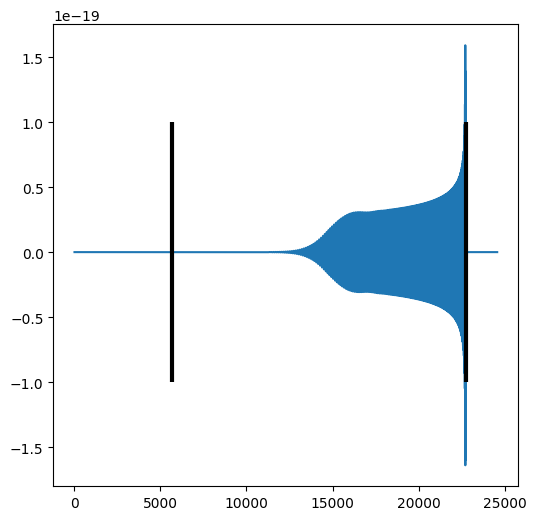

In [51]:
print(len(signals[0])/2048.)
plt.figure(figsize=(6.0, 6.0))
crop = int(2.5*2048.)
plt.plot(signals[0][crop:-crop])
plt.vlines(waveform_kwargs['tc']*2048., -1e-19, 1e-19, colors='k', linewidth=3.0)
plt.vlines(((waveform_kwargs['tc']-10.84)+2.5)*2048., -1e-19, 1e-19, colors='k', linewidth=3.0)
plt.show()

In [52]:
mass1 = 7.0
mass2 = 7.0
mc = (mass1*mass2 / (mass1+mass2)**2.)**(3./5) * (mass1 + mass2)
print(mc)

6.093853943072869


### MR sampling params

In [53]:
def get_time_at_freq(t, f, search_freq):
    idx = (np.abs(f - search_freq)).argmin()
    time_at_search_freq = t[idx]
    return time_at_search_freq

def get_freq_at_time(t, f, search_time):
    # t is 0.0 at tc and negative otherwise
    idx = (np.abs(t - search_time)).argmin()
    freq_at_search_time = f[idx]
    return freq_at_search_time

In [54]:
""" Post Fudge Factor """
# Get fudge factor that accounts for wrap around from PyCBC
# This can be used to estimate the merger+ringdown leeway for MR sampling
# This should account for waveform content after tc
prior_high_mass = 50.0
m_final, spin_final = get_final_from_initial(mass1=prior_high_mass, 
                                             mass2=prior_high_mass, 
                                             spin1z=0.99, spin2z=0.99)
post_fudge_factor = tau_from_final_mass_spin(m_final, spin_final) * 10 * 1.5 # just in case
# Adding light travel time between detectors H1 and V1 (We use H1 and L1 for ORChiD, but just in case)
light_travel_time = Detector('H1').light_travel_time_to_detector(Detector('V1')) * 1.1
post_fudge_factor += light_travel_time
print('Post fudge duration = {} s'.format(post_fudge_factor))

Post fudge duration = 0.15254853361070325 s


In [55]:
""" Pre Fudge Factor """
# Calculate fudge factor at left end of the waveform injection
# Get t, f from lowest mass binary system
prior_low_mass = 7.0
decimation_start_freq = f_schwarzchild_isco(prior_low_mass + prior_low_mass)
t, f = get_tf_evolution_before_tc(prior_low_mass, 
                                  signal_low_freq_cutoff, 
                                  sample_rate)
time_at_decim_start_freq = get_time_at_freq(t, f, search_freq=decimation_start_freq)
# The times should vary from 0.0 to -tau starting at tc
light_travel_time = Detector('H1').light_travel_time_to_detector(Detector('V1')) * 1.1
pre_fudge_factor = (light_travel_time + (-time_at_decim_start_freq)) * 1.1 # just in case
print('Pre fudge duration = {} s'.format(pre_fudge_factor))

Pre fudge duration = 0.05138703255673469 s


In [56]:
def get_imr_chirp_time(m1, m2, s1z, s2z, fl):
    return 1.1 * lalsim.SimIMRPhenomDChirpTime(m1*1.989e+30, m2*1.989e+30, s1z, s2z, fl)

max_signal_length = get_imr_chirp_time(7.0, 7.0, 0.99, 0.99, 20.0)
print(max_signal_length)

12.738461872620855


In [57]:
# Calculate injections time priors
_longest_wavelen = get_imr_chirp_time(prior_low_mass, prior_low_mass, 0.99, 0.99, signal_low_freq_cutoff)
post_fudge_factor = post_fudge_factor
# tc params
signal_length = 12.0
noise_pad = 0.6
tc_diff = 0.2 # seconds
tc_inject_lower = signal_length - (noise_pad + post_fudge_factor + tc_diff)
tc_inject_upper = tc_inject_lower + tc_diff
# assert tc_inject_lower > _longest_wavelen, 'longest waveform does not fit within provided signal len!'

print(tc_inject_lower, tc_inject_upper)

11.047451466389298 11.247451466389297


In [58]:
# Function to obtain frequencies wrt time
t_longest, f_longest = get_tf_evolution_before_tc(prior_low_mass, 
                                  signal_low_freq_cutoff, 
                                  4096.)

(0.0, 1850.0)

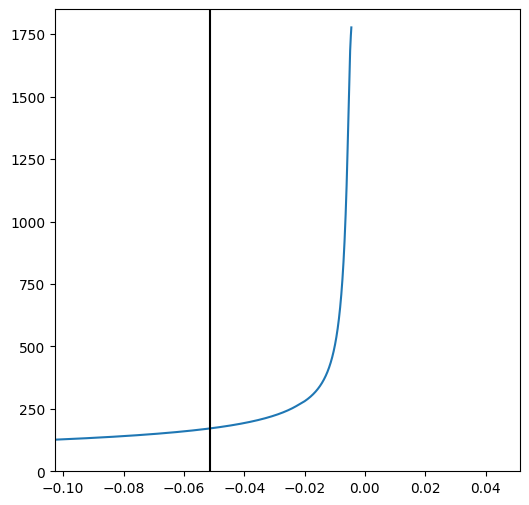

In [59]:
plt.figure(figsize=(6.0, 6.0))
plt.plot(t, f)
plt.vlines(-pre_fudge_factor, -1000, +2000.0, colors='k')
plt.xlim(-pre_fudge_factor*2, pre_fudge_factor)
plt.ylim(0.0, 1850.0)

In [60]:
# pre-fudge factor before tc at which we start decimation
search_time = -pre_fudge_factor
freq_given_time = get_freq_at_time(t_longest, f_longest, search_time=search_time)
print('Frequency at pre-fudge factor = {} Hz'.format(freq_given_time))

Frequency at pre-fudge factor = 171.52216040425128 Hz


### Plotting MR sampling example

In [61]:
# CLEANED
def updated_sampling_rate_bins(low_mass=7.0, 
                               sample_length=12.0, 
                               signal_low_freq_cutoff=20.0,
                               sample_rate=2048., 
                               tc_inject_lower=tc_inject_lower, tc_inject_upper=tc_inject_upper,
                               ringdown_leeway=post_fudge_factor, merger_leeway=pre_fudge_factor, 
                               fs_reduction_factor=1.8, 
                               f_reduction_factor=2.0,
                               lowest_possible_fs=128.0):
    
    ## Evaluate all params for longest signal in prior
    # Useful functions
    t_given_f = lambda _f: get_time_at_freq(t_longest, f_longest, search_freq=_f)
    f_given_t = lambda _t: get_freq_at_time(t_longest, f_longest, search_time=_t)
    clip_fs = lambda fs: fs if fs>=lowest_possible_fs else lowest_possible_fs
    closest_power_of_2 = lambda foo: 2**(math.ceil(math.log(foo, 2)))
    add_buffer = lambda foo: foo + 40.0

    # Calculate f_ISCO for reference
    f_ISCO = f_schwarzchild_isco(low_mass + low_mass)
    # Get frequency at given time (using 4096 Hz for high resolution mapping)
    t_longest, f_longest = get_tf_evolution_before_tc(low_mass, 
                                                      signal_low_freq_cutoff, 
                                                      4096.0)
    # Each sample in t with longest waveform injected at tc_inject_lower
    end_time = sample_length - tc_inject_lower 
    start_time = -tc_inject_lower # tc_inject_lower is location of relative_t=0.0 
    times = np.linspace(start_time, end_time, int(sample_length*sample_rate))

    # pre-fudge factor before tc at which we start decimation (171.52 Hz)
    freq_at_pre_fudge = get_freq_at_time(t_longest, f_longest, search_time=-pre_fudge_factor)
    # Frequencies at which we reduce the sampling rate (till signal low frequency cutoff)
    check_freq = freq_at_pre_fudge
    edge_freqs = [check_freq]
    # fs is the closest power of 2 above given lowest possible fs
    # Any fs below lowest possible fs (that is a power of 2) is clipped to the lowest possible power of 2 fs
    sampling_rates = [clip_fs(closest_power_of_2(add_buffer(check_freq*2.0)))]
    while check_freq >= 20.0:
        check_freq /= 2.0
        edge_freqs.insert(0, check_freq)
        sampling_rates.insert(0, clip_fs(closest_power_of_2(add_buffer(check_freq*2.0))))
    # Get times at which the above freqs occur in the longest waveform injected at tc_inject_lower
    # These values will negative
    edge_times = [t_given_f(_f) for _f in edge_freqs]
    # Add edge times based on times variable
    edge_times.insert(0, start_time) # global start time
    sampling_rates.insert(0, lowest_possible_fs)
    # end time of injection (tc_diff + post_fudge_factor)
    edge_times.append((tc_inject_upper-tc_inject_lower) + post_fudge_factor)
    sampling_rates.append(int(sample_rate))
    # Added end time of sample
    edge_times.append(end_time)
    sampling_rates.append(lowest_possible_fs)
    print(sampling_rates)
    print(edge_times)
    # idx of time edges taken from the times var
    edge_idxs = np.array([np.absolute(times - edge_time).argmin() for edge_time in edge_times])
    edge_idxs[-1] = int(sample_length * sample_rate)
    print(edge_idxs)
    # Indices and their sampling rates
    detailed_bins = [[edge_idxs[n], edge_idxs[n+1], sampling_rates[n+1]] for n in range(len(edge_idxs)-1)]
    print(detailed_bins)
    # Combine same sampling frequencies
    updated_bins = [detailed_bins[0]]
    for n, foo in enumerate(detailed_bins[1:]):
        if foo[2] == detailed_bins[n][2]:
            updated_bins[-1][1] = foo[1]
        else:
            updated_bins.append(foo)
    print(updated_bins)
    # Return contains (bin_start_idx, bin_end_idx, sample_rate_required)
    return np.array(updated_bins)

In [62]:
updated_sampling_rate_bins()

[128.0, 128.0, 128, 128, 256, 512, 2048, 128.0]
[-11.047451466389298, -11.586015009726053, -9.651705037366229, -1.575175819687688, -0.26623225702984193, -0.05138604280260859, 0.35254853361070254, 0.9525485336107025]
[    0     0  2858 19398 22079 22519 23346 24576]
[[0, 0, 128.0], [0, 2858, 128], [2858, 19398, 128], [19398, 22079, 256], [22079, 22519, 512], [22519, 23346, 2048], [23346, 24576, 128.0]]
[[0, 19398, 128.0], [19398, 22079, 256], [22079, 22519, 512], [22519, 23346, 2048], [23346, 24576, 128.0]]


array([[    0., 19398.,   128.],
       [19398., 22079.,   256.],
       [22079., 22519.,   512.],
       [22519., 23346.,  2048.],
       [23346., 24576.,   128.]])

In [63]:
def get_sampling_rate_bins(low_mass=7.0, max_signal_length=12.0, signal_low_freq_cutoff=20.0,
                           sample_rate=2048., tc_inject_lower=tc_inject_lower, tc_inject_upper=tc_inject_upper,
                           ringdown_leeway=0.1, merger_leeway=0.1, start_freq_factor=2.5,
                           fs_reduction_factor=1.8, fbin_reduction_factor=2.0):
    # Signal low freq cutoff is taken to happen at max_signal_length for worst case
    ## Approximate value for f_ISCO with BBH system both with lowest mass in priors
    # f_ISCO = 4400./(low_mass+low_mass) # Hz
    ## Closer value of f_ISCO
    f_ISCO = f_schwarzchild_isco(low_mass + low_mass)
    # Get necessary constants
    C = signal_low_freq_cutoff/f_ISCO # used to obtain upper fval when freq>=f_ISCO
    # Function to obtain frequencies wrt time
    f_check = lambda t_: signal_low_freq_cutoff/((t_/max_signal_length)**(3./8.) + C * delta(t_))
    # delta function at dt_merg_old == 0.0, to activate 'C'
    delta = lambda t_: 1.0 if t_==0 else 0.0
    # Clip the frequency response for all values greater than f_ISCO
    clip_f = lambda f_: f_ISCO if f_>f_ISCO else f_
    
    # Times given as input to get the frequencies must take into account tc_inject_lower
    offset = max_signal_length - tc_inject_lower
    # Getting the bins with decaying sampling frequencies
    offset_signal_length = max_signal_length - offset
    t = np.linspace(-1.0*offset, offset_signal_length, int(max_signal_length*sample_rate))
    
    # Get check frequencies
    f_edge = f_ISCO
    f_hqual = 750.0 # high-quality
    f_bad = 50.0
    bad_chunk = True
    hqual_chunk = True
    bins = [0] # bin always starts at 0
    save_f = []
    for n, t_ in enumerate(t):
        # The last bin end val will be the last value in signal
        if f_edge < signal_low_freq_cutoff:
            break
        # Adding a tc_upper and ringdown leeway
        leeway = tc_inject_upper - tc_inject_lower + ringdown_leeway
        if (t_ < 0.0 and t_ >= -1*leeway) or (t_ > 0.0 and t_ < merger_leeway):
            f = f_hqual
        elif t_ > 0 and t_ > merger_leeway:
            f = clip_f(f_check(t_))
        else:
            f = f_bad # bad value check
        
        # Save output response for plotting
        save_f.append(f)
            
        # Adding the freq edges
        if f == f_hqual and bad_chunk:
            # this is where the bad chunk ends and ringdown+merger phase should start
            bins.append(n)
            bad_chunk = False
        elif f < f_hqual and f > f_ISCO/2.0 and hqual_chunk:
            # if freq is f_ISCO, we transition into inspiral phase from ringdown+merger phase
            # this should correspond to the ringdown phase and add a merger leeway
            bins.append(n)
            hqual_chunk = False
        elif f < f_edge/fbin_reduction_factor and f != f_bad:
            # get the time when frequency of the inspiral reduces by a factor of 2.0
            bins.append(n)
            f_edge = f_edge/fbin_reduction_factor
            
    bins.append(len(t))
    save_f = np.array(save_f)
    
    # Add the bins and sampling frequency for the pure noise chunks
    bad_bin = [[bins[0], bins[1], 64.0]] # using low sampling freq for bad bin
    hqual_bin = [[bins[1], bins[2], sample_rate]] # using highest sampling freq for ringdown+merger pahse
    # Starting freq. at time of merger is given based on f_ISCO
    # We use a sampling freq. a factor of 4 higher than f_ISCO
    if start_freq_factor < 2.0:
        raise ValueError("Reduction factor has to be *at least* 2.0 to abide by the Nyquist Limit")
    if start_freq_factor == 2.0:
        warnings.warn("buffer_factor is at Nyquist Limit. Good performace is not gauranteed.")
    
    # Set the starting frequency based on a buffer_factor
    start_freq = f_ISCO * start_freq_factor
    # Get the bin start and end idx along with the required sampling rate
    # Two bin addition are already done above, so we start range at 2
    detailed_bins = [[bins[n], bins[n+1], start_freq/fs_reduction_factor**(n-2)] for n in range(2, len(bins[:-1]))]
    # Adding bad bins
    detailed_bins = bad_bin + hqual_bin + detailed_bins
    # Manipulate detailed bins to account for reversed perspective of sample
    man = lambda b: int(max_signal_length*sample_rate) - b
    detailed_bins = [[man(b[1]), man(b[0]), b[2]] for b in detailed_bins]
    # Sort the bins based on start idx so its easier to concatenate later on
    detailed_bins = sorted(detailed_bins, key=itemgetter(0))
    # Return contains (bin_start_idx, bin_end_idx, sample_rate_required)
    return np.array(detailed_bins)

In [64]:
def multirate_sampling():
    # Downsample the data into required sampling rates and slice intervals
    # These intervals are stitched together to for a sample with MRsampling
    # Reading the signal
    signals = generate()
    signal_low_freq_cutoff = 20.0 # Hz
    sample_rate = 2048. # Hz
    # Removing chunk manually here. In pipeline, whitening will remove this as corrupt region.
    signals = [signal[int(2.5*2048.):int(len(signal)-2.5*2048.)] for signal in signals]
    # Get the sampling rates and their bins idx
    dbins = updated_sampling_rate_bins(signal_low_freq_cutoff=signal_low_freq_cutoff, 
                                       sample_rate=sample_rate)
    
    multirate_chunks = []
    new_sample_rates = []
    num_samples_original = []
    # Now downsample the signals from both detectors based on dbins
    for start_idx, end_idx, new_sample_rate in dbins:
        new_sample_rates.append(new_sample_rate)
        if new_sample_rate != sample_rate:
            # Calculate decimation factor
            decimation_factor = int(round(sample_rate/new_sample_rate))
            # Decimation of signals based on decimation factor
            """
            Downsample the signal after applying an anti-aliasing filter.
            By default, an order 8 Chebyshev type I filter is used. 
            A 30 point FIR filter with Hamming window is used if ftype is ‘fir’.
            
            Decimation factor, specified as a positive integer. 
            For better results when 'r' is greater than 13, divide 'r' into 
            smaller factors and call decimate several times.
            
            """
            
            # Sanity check
            if decimation_factor > 13:
                tmp_signals = signals[:]
                # The decimation factor should always be of type 2**n
                # So factorisation should be quite straight-forward (depricated on April 1st, 2022)
                # Is the above deprication an April's Fools joke? Absolutely not.
                
                # Prime-factorisation
                factors = prime_factors(decimation_factor)
                factors = np.array(factors)
                if len(factors) == 1:
                    raise ValueError("The decimation factor is prime and > 13. There are no factors.")
                if len(factors[factors>13]) > 0:
                    raise ValueError("One or more prime factors > 13. Edit buffer_factor to try get rid of this.")
                    
                # Decimate the signal 'n' times by a decimation factor of 2.0
                for factor in factors:
                    tmp_signals = [decimate(signal, factor) for signal in tmp_signals]
                # Store the final decimated signal
                decimated_signals = tmp_signals
                
            else:
                decimated_signals = [decimate(signal, decimation_factor) for signal in signals]
            
            # Now slice the appropriate parts of the decimated signals using bin idx
            # Note than the bin idx was made using the original sampling rate
            num_samples_original_i = len(signals[0])
            num_samples_decimated = int(num_samples_original_i/decimation_factor)
            
            ## Convert the bin idxs to decimated idxs
            _tmp = end_idx-start_idx
            assert _tmp == len(signals[0][int(start_idx):int(end_idx)])
            num_samples_original.append(_tmp)
            # Normalise the bin idxs
            start_idx_norm = start_idx/num_samples_original_i
            end_idx_norm = end_idx/num_samples_original_i
            # Using the normalised bins idxs, get the decimated idxs
            sidx_dec = int(start_idx_norm * num_samples_decimated)
            eidx_dec = int(end_idx_norm * num_samples_decimated)
            
            # Slice the decimated signals using the start and end decimated idx
            chunk = [signal[sidx_dec:eidx_dec] for signal in decimated_signals]
        else:
            # No decimation done, original sample rate is used
            _tmp = end_idx-start_idx
            assert _tmp == len(signals[0][int(start_idx):int(end_idx)])
            num_samples_original.append(_tmp)

            chunk = [signal[int(start_idx):int(end_idx)] for signal in signals]
        
        # Append the decimated chunk together
        multirate_chunks.append(np.stack(chunk, axis=0))
    
    # Now properly concatenate all the decimated chunks together using numpy
    multirate_signals = np.column_stack(tuple(multirate_chunks))
    # Display diagnostics
    print("\nDetailed bins for the given configuration:")
    for i, j, k in dbins:
        print("Range = [{}, {}] -> {} Hz".format(i, j, k))
    print("\nOriginal length of the signals (in num) = {}".format(len(signals[0])))
    print("Multirate length of the signals (in num) = {}".format(len(multirate_signals[0])))
    print("Factor reduction = {}".format(len(signals[0])/len(multirate_signals[0])))
    print("Equivalent length of signal in original sampling freq = {}".format(len(multirate_signals[0])/sample_rate))
    return signals, multirate_signals, multirate_chunks, new_sample_rates, num_samples_original


[128.0, 128.0, 128, 128, 256, 512, 2048, 128.0]
[-11.047451466389298, -11.586015009726053, -9.651705037366229, -1.575175819687688, -0.26623225702984193, -0.05138604280260859, 0.35254853361070254, 0.9525485336107025]
[    0     0  2858 19398 22079 22519 23346 24576]
[[0, 0, 128.0], [0, 2858, 128], [2858, 19398, 128], [19398, 22079, 256], [22079, 22519, 512], [22519, 23346, 2048], [23346, 24576, 128.0]]
[[0, 19398, 128.0], [19398, 22079, 256], [22079, 22519, 512], [22519, 23346, 2048], [23346, 24576, 128.0]]

Detailed bins for the given configuration:
Range = [0.0, 19398.0] -> 128.0 Hz
Range = [19398.0, 22079.0] -> 256.0 Hz
Range = [22079.0, 22519.0] -> 512.0 Hz
Range = [22519.0, 23346.0] -> 2048.0 Hz
Range = [23346.0, 24576.0] -> 128.0 Hz

Original length of the signals (in num) = 24576
Multirate length of the signals (in num) = 2561
Factor reduction = 9.596251464271768
Equivalent length of signal in original sampling freq = 1.25048828125


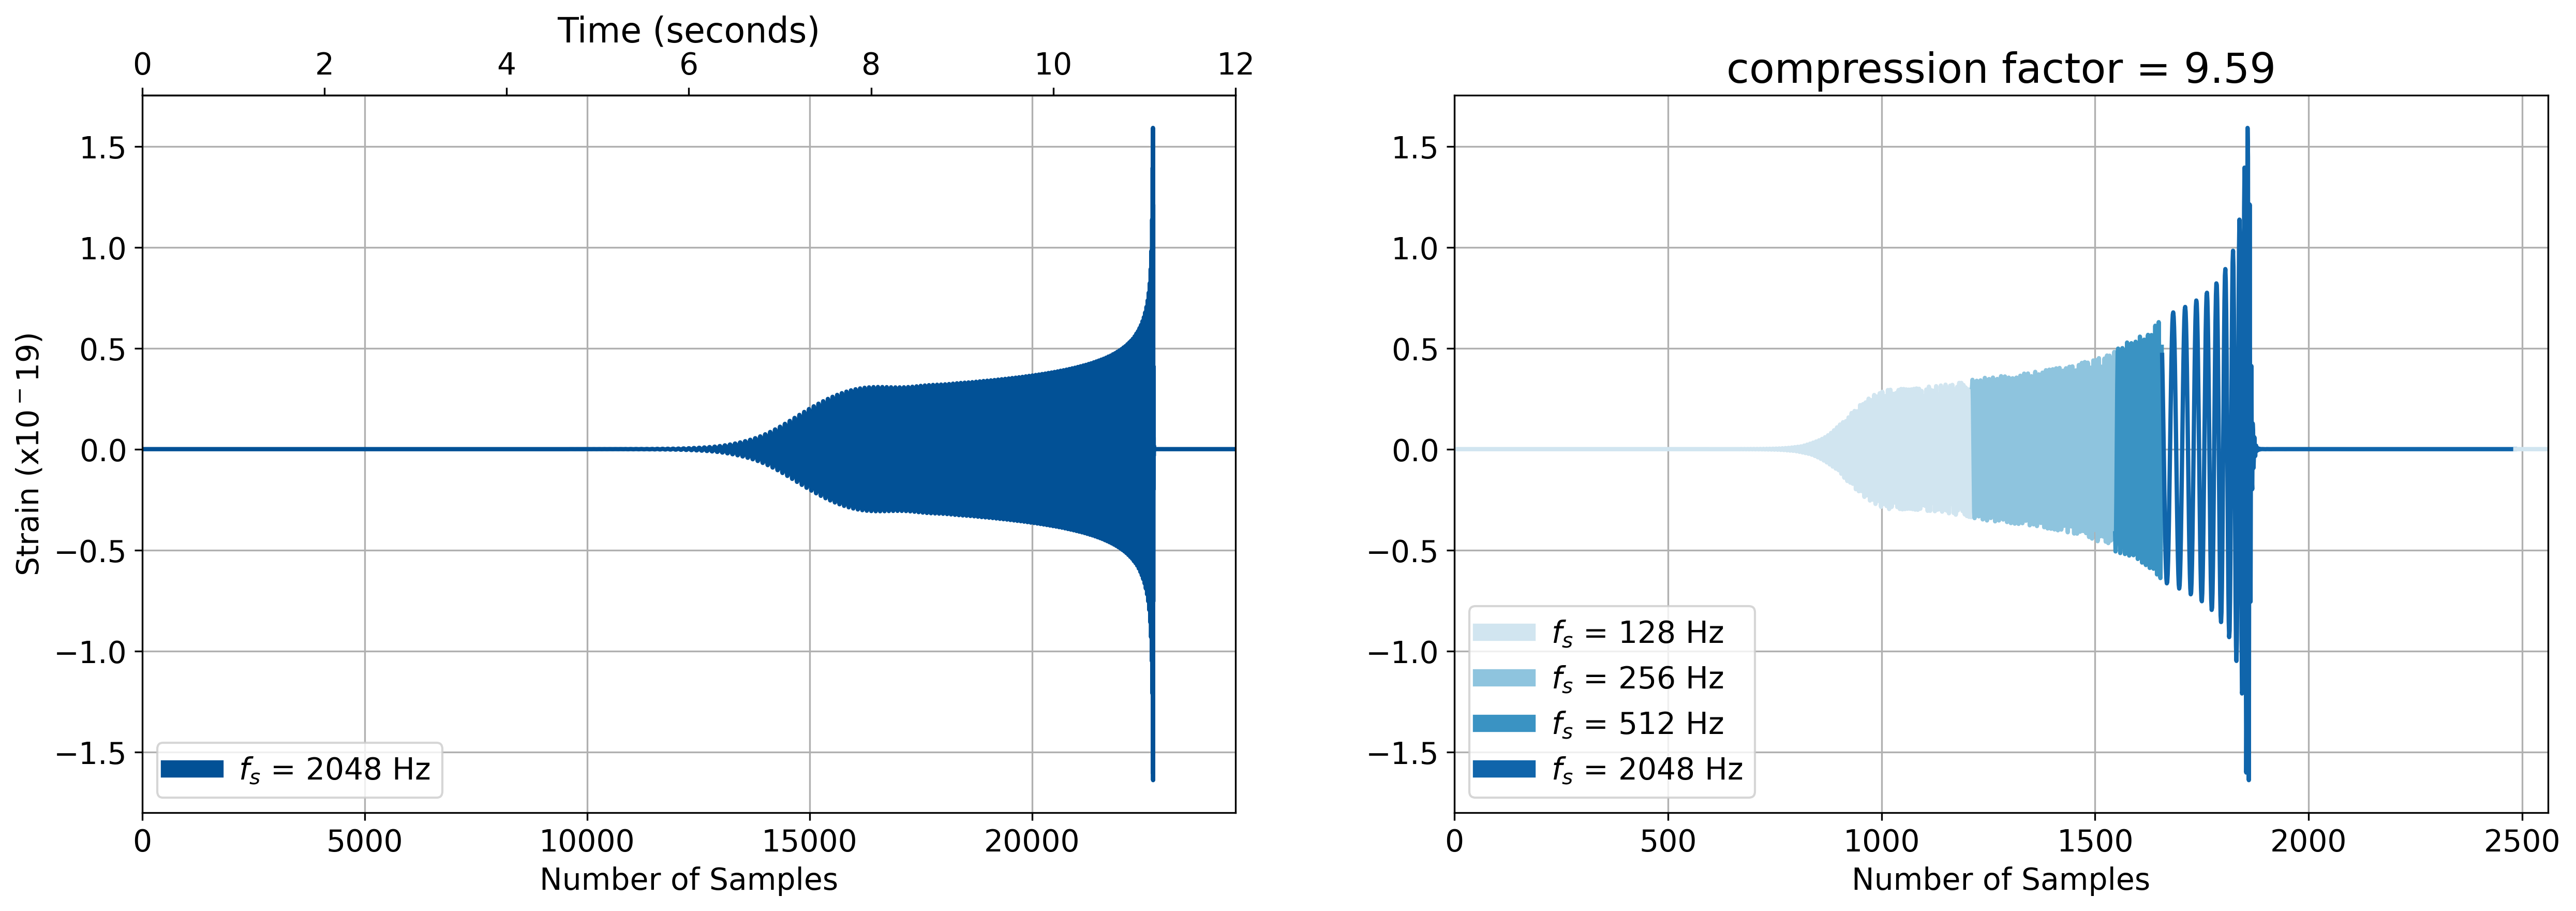

'\n[128.0, 128.0, 128, 128, 256, 512, 2048, 128.0]\n[-13.147451466389297, -11.586015009726053, -9.651705037366229, -1.575175819687688, -0.26623225702984193, -0.05138604280260859, 0.35254853361070254, 1.8525485336107028]\n[    0  3198  7159 23699 26380 26820 27647 30720]\n[[0, 3198, 128.0], [3198, 7159, 128], [7159, 23699, 128], [23699, 26380, 256], [26380, 26820, 512], [26820, 27647, 2048], [27647, 30720, 128.0]]\n[[0, 23699, 128.0], [23699, 26380, 256], [26380, 26820, 512], [26820, 27647, 2048], [27647, 30720, 128.0]]\n\nDetailed bins for the given configuration:\nRange = [0.0, 23699.0] -> 128.0 Hz\nRange = [23699.0, 26380.0] -> 256.0 Hz\nRange = [26380.0, 26820.0] -> 512.0 Hz\nRange = [26820.0, 27647.0] -> 2048.0 Hz\nRange = [27647.0, 30720.0] -> 128.0 Hz\n\nOriginal length of the signals (in num) = 30720\nMultirate length of the signals (in num) = 2946\nFactor reduction = 10.427698574338086\nEquivalent length of signal in original sampling freq = 1.4384765625\n'

In [84]:
# Get the normal and multirate version of the input signals
signals, multirate_signals, chunks, srs, norig = multirate_sampling()

# ax = figure(title="Comparing fixed sample rate signals & their multirate counterparts")
fig, ax = plt.subplots(1, 2, figsize=(20.0, 6.0), dpi=300)

plt.rcParams.update({'font.size': 16})

""" Pure Signals and Multi-rate Pure Signals """
assert len(list(set([len(signal) for signal in signals]))) == 1
assert len(list(set([len(signal) for signal in multirate_signals]))) == 1

time_axis = np.arange(len(signals[0]))
ax[0].plot(time_axis, signals[0]/1e-19, c=np.array([2, 81, 150])/255., label=r'$f_s$ = 2048 Hz', linewidth=2.0)
ax[0].grid(True, which='both')
ax[0].set_xlim(0, len(time_axis))
ax[0].set_xlabel('Number of Samples')
ax[0].set_ylabel(r'Strain (x$10^-19$)')

time_axis_chunks = []
svalue = 0
for chunk in chunks:
    evalue = len(chunk[0]) + svalue
    taxis = np.arange(svalue, evalue)
    time_axis_chunks.append(taxis)
    svalue = evalue

# Blues
colors = [np.array([209, 229, 240])/255.,
          np.array([142, 196, 222])/255., 
          np.array([58, 147, 195])/255., 
          np.array([16, 101, 171])/255.,
          np.array([209, 229, 240])/255., 
          np.array([142, 196, 222])/255., 
          np.array([194, 106, 119])/255.]

# ORYB
_colors = [np.array([235, 97, 35])/255.,
          np.array([191, 44, 35])/255., 
          np.array([253, 179, 56])/255., 
          np.array([2, 81, 150])/255.,
          np.array([235, 97, 35])/255.,
          np.array([142, 196, 222])/255., 
          np.array([194, 106, 119])/255.]

# RYGB (Macaw)
_colors = [np.array([191, 44, 35])/255., 
          np.array([253, 179, 56])/255.,
          np.array([41, 94, 17])/255.,
          np.array([2, 81, 150])/255.,
          np.array([191, 44, 35])/255.]

start = 0
for n, chunk in enumerate(chunks):
    if n == len(chunks)-1:
        label = None
    else:
        label = r'$f_s$ = {} Hz'.format(int(srs[n]))
    
    # ax[1].axvspan(start, start+len(chunk[0]), facecolor=colors[n], alpha=0.5)
    ax[1].plot(time_axis_chunks[n], chunk[0]/1e-19, c=colors[n], label=label, linewidth=2.0)
    ax[1].grid(True, which='both')
    ax[1].set_xlim(0, max(time_axis_chunks[-1]))
    ax[1].set_xlabel('Number of Samples')
    ax[1].set_title('compression factor = 9.59')
    start+=len(chunk[0])


leg1 = ax[0].legend(loc='lower left', handlelength=1.5, fontsize=14)
leg2 = ax[1].legend(loc='lower left', handlelength=1.5, fontsize=14)
# change the line width for the legend
for line in leg1.get_lines():
    line.set_alpha(1.0)
    line.set_linewidth(8.0)
    line.set_linewidth(8.0)

for line in leg2.get_lines():
    line.set_alpha(1.0)
    line.set_linewidth(8.0)
    line.set_linewidth(8.0)

# Create secondary x-axis
x_to_altx = lambda x: x/2048.
altx_to_x = lambda altx: altx*2048.
secax = ax[0].secondary_xaxis('top', functions=(x_to_altx, altx_to_x))
secax.set_xlabel('Time (seconds)')

ax[0].tick_params(axis='both', which='major', labelsize=fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=fontsize)
secax.tick_params(axis='both', which='major', labelsize=fontsize)

plt.savefig("./paper/multirate_sampling_example.png", bbox_inches='tight')
plt.show()
plt.close()

### REF outputs
"""
[128.0, 128.0, 128, 128, 256, 512, 2048, 128.0]
[-13.147451466389297, -11.586015009726053, -9.651705037366229, -1.575175819687688, -0.26623225702984193, -0.05138604280260859, 0.35254853361070254, 1.8525485336107028]
[    0  3198  7159 23699 26380 26820 27647 30720]
[[0, 3198, 128.0], [3198, 7159, 128], [7159, 23699, 128], [23699, 26380, 256], [26380, 26820, 512], [26820, 27647, 2048], [27647, 30720, 128.0]]
[[0, 23699, 128.0], [23699, 26380, 256], [26380, 26820, 512], [26820, 27647, 2048], [27647, 30720, 128.0]]

Detailed bins for the given configuration:
Range = [0.0, 23699.0] -> 128.0 Hz
Range = [23699.0, 26380.0] -> 256.0 Hz
Range = [26380.0, 26820.0] -> 512.0 Hz
Range = [26820.0, 27647.0] -> 2048.0 Hz
Range = [27647.0, 30720.0] -> 128.0 Hz

Original length of the signals (in num) = 30720
Multirate length of the signals (in num) = 2946
Factor reduction = 10.427698574338086
Equivalent length of signal in original sampling freq = 1.4384765625
"""

### Reconstructing the MR sampled signal

In [66]:
print(norig)
print(sum(norig))

[19398.0, 2681.0, 440.0, 827.0, 1230.0]
24576.0


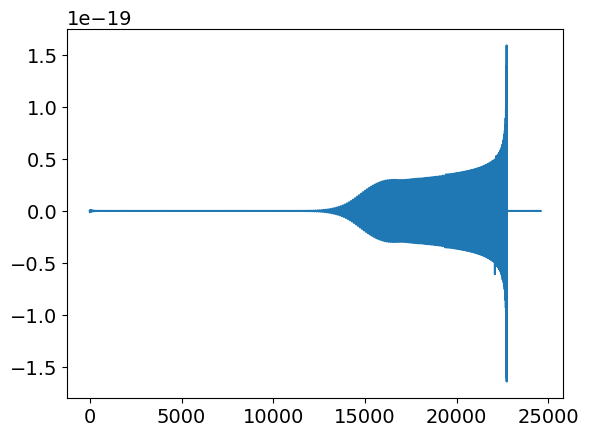

In [67]:
from scipy.signal import resample
new_chunks = []
for n, chunk in enumerate(chunks):
    if srs[n] == 2048.0:
        new_chunks.append(chunk[0])
        continue
    new_num_samples = int(norig[n])
    foo = resample(chunk[0], new_num_samples)
    new_chunks.append(foo)

reconstructed = np.concatenate(new_chunks)
plt.plot(reconstructed)

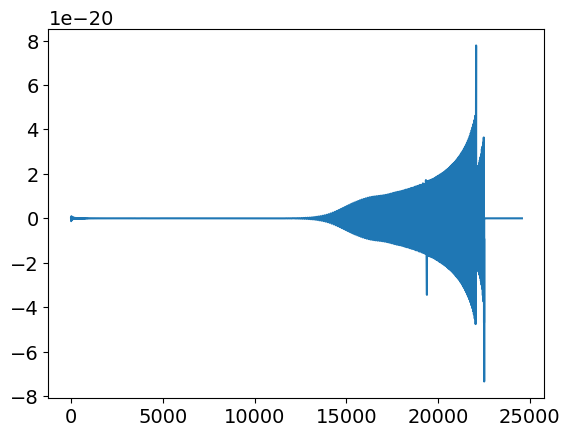

In [68]:
# Compute the residual
plt.plot(reconstructed - signals[0])
#plt.vlines(int(13.2*2048.)-int((pre_fudge_factor)*2048.), -1, 1, colors='k')
#plt.ylim(-3e-20, 1e-20)

### MR Template plot

In [69]:
# Font and plot parameters
plt.rcParams.update({'font.size': 10})
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

In [70]:
dbins = updated_sampling_rate_bins()

[128.0, 128.0, 128, 128, 256, 512, 2048, 128.0]
[-11.047451466389298, -11.586015009726053, -9.651705037366229, -1.575175819687688, -0.26623225702984193, -0.05138604280260859, 0.35254853361070254, 0.9525485336107025]
[    0     0  2858 19398 22079 22519 23346 24576]
[[0, 0, 128.0], [0, 2858, 128], [2858, 19398, 128], [19398, 22079, 256], [22079, 22519, 512], [22519, 23346, 2048], [23346, 24576, 128.0]]
[[0, 19398, 128.0], [19398, 22079, 256], [22079, 22519, 512], [22519, 23346, 2048], [23346, 24576, 128.0]]


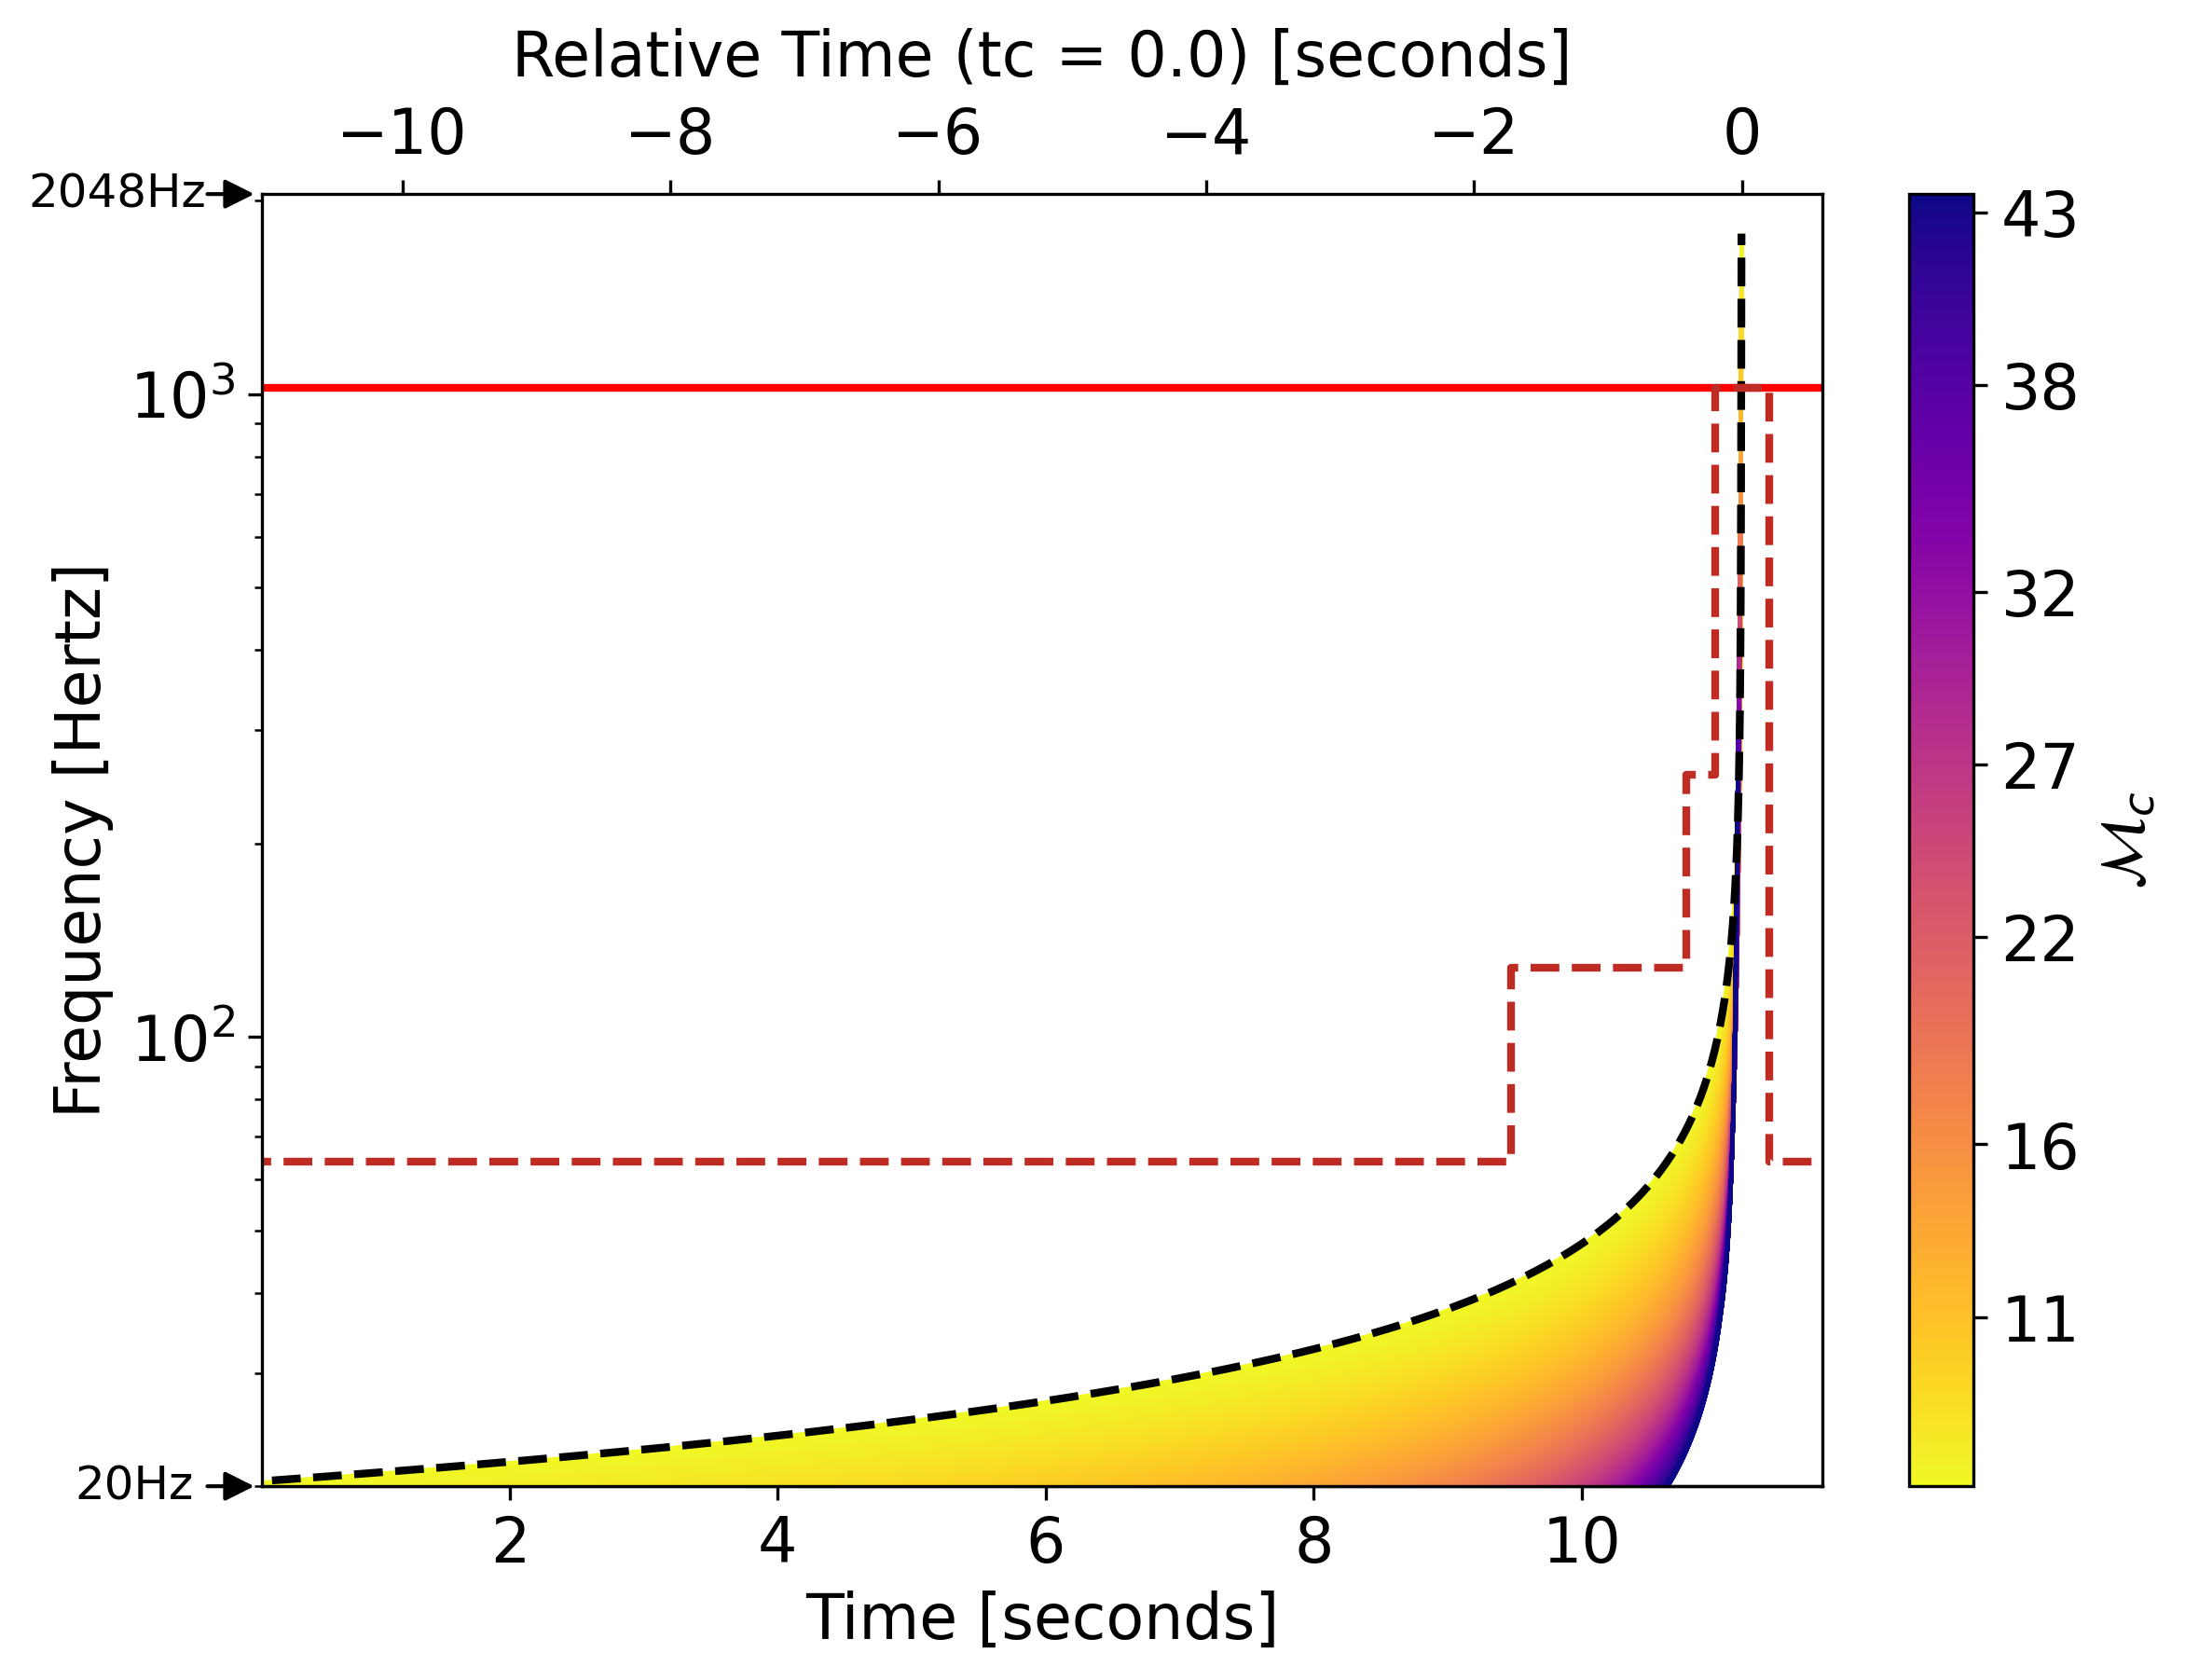

In [89]:
mass1 = 50.0
mass2 = 50.0
eta = mass1*mass2 / (mass1 + mass2)**2.
max_mchirp = eta**(3./5) * (mass1 + mass2)
mass1 = 7.0
mass2 = 7.0
eta = mass1*mass2 / (mass1 + mass2)**2.
min_mchirp = eta**(3./5) * (mass1 + mass2)

fontsize = 16
fig, ax = plt.subplots(figsize=(8.0, 6.0), dpi=300)

for mass1 in np.linspace(7.1, 50.0, 1024):
    mass2 = mass1 - 0.1
    assert mass1 > mass2

    t, f = pnutils.get_inspiral_tf(tc=0.0, mass1=mass1, mass2=mass2, 
                                   spin1=0.99, spin2=0.99, 
                                   f_low=20.0, n_points=512, 
                                   pn_2order=7, 
                                   approximant='IMRPhenomD')

    eta = mass1*mass2 / (mass1 + mass2)**2.
    norm = lambda val: (val - min_mchirp)/(max_mchirp - min_mchirp)
    mchirp = norm(eta**(3./5) * (mass1 + mass2))
    ax.plot(t, f, linewidth=1.0, c=cm.plasma_r(mchirp))

# Longest waveform in prior
M = 14.0 # total lowest mass in prior
f_ISCO_highest = f_schwarzchild_isco(M)
t_highest, f_highest = pnutils.get_inspiral_tf(tc=0.0, mass1=7., mass2=7., 
                               spin1=0.99, spin2=0.99, 
                               f_low=20.0, n_points=512, 
                               pn_2order=7, 
                               approximant='IMRPhenomD')

# Plotting
ax.plot(t_highest, f_highest, linestyle='dashed', linewidth=2.0, color='k')

ax.axhline(1024.0, color='red', linestyle='solid', linewidth=2.0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

## Add arrows to specific points on y-axis
# Low-frequency cutoff
ax.annotate('', xy=(0, 0), xycoords='axes fraction', textcoords='axes fraction',
            xytext=(-0.04, 0), arrowprops=dict(arrowstyle="-|>", color='k'))
ax.annotate('20Hz', xy=(-0.12, -0.01), xycoords='axes fraction', fontsize=12)
# Maximum sampling rate
ax.annotate('', xy=(0, 1), xycoords='axes fraction', textcoords='axes fraction',
            xytext=(-0.04, 1), arrowprops=dict(arrowstyle="-|>", color='k'))
ax.annotate('2048Hz', xy=(-0.15, 0.99), xycoords='axes fraction', fontsize=12)

# Padding
lpad = tc_inject_lower - imr_chirp_time(7., 7., 0.99, 0.99, 20.)
rpad = 12.0 - (tc_inject_upper + post_fudge_factor)
tc = (tc_inject_upper + tc_inject_lower)/2. + 0.05

# Plotting the updated Nyquist limit
x = []
y = []
for foo in dbins:
    x.extend([foo[0]/2048.-tc, foo[1]/2048.-tc])
    y.extend([foo[2]/2., foo[2]/2.])

# Limits of waveform placement
# ax.axvline((-imr_chirp_time(7., 7., 0.99, 0.99, 20.)*1.1)-(tc-tc_inject_lower), color='k', linestyle='dotted')
# ax.axvline((tc_inject_upper-tc)+post_fudge_factor, color='k', linestyle='dotted')

ax.plot(x, y, linestyle='dashed', c=np.array([191, 44, 35])/255., linewidth=2.0)

# Create secondary x-axis
x_to_altx = lambda x: x + tc
altx_to_x = lambda altx: altx - tc
secax = ax.secondary_xaxis('bottom', functions=(x_to_altx, altx_to_x))
secax.set_xlabel('Time [seconds]', fontsize=fontsize)

ax.set_ylabel('Frequency [Hertz]', fontsize=fontsize)
ax.set_xlabel('Relative Time (tc = 0.0) [seconds]', labelpad=7.5, fontsize=fontsize)
ax.set_ylim(20.0, 2048.)
ax.set_yscale('log')
ax.set_xlim(-imr_chirp_time(7., 7., 0.99, 0.99, 20.)-lpad, rpad)

plt.tick_params(axis='both', which='major', labelsize=fontsize)
secax.tick_params(axis='both', which='major', labelsize=fontsize)

# Colorbar
mass1 = 7.0
mass2 = 7.0
mc_lower = (mass1*mass2 / (mass1+mass2)**2.)**(3./5) * (mass1 + mass2)
mass1 = 50.0
mass2 = 50.0
mc_upper = (mass1*mass2 / (mass1+mass2)**2.)**(3./5) * (mass1 + mass2)

c = np.linspace(mc_lower, mc_upper, 8, dtype=int)
norm = mpl.colors.Normalize(vmin=mc_lower, vmax=mc_upper)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma_r)
cmap.set_array([])

cbar = plt.colorbar(cmap, ax=plt.gca(), ticks=c, fraction=.05, pad=0.05)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'$\mathcal{M}_c$', size=fontsize)

plt.savefig("./paper/multirate_sampling_template.png", bbox_inches='tight')
plt.draw()
plt.show()

In [ ]:
c = np.linspace(mc_lower, mc_upper, 8, dtype=int)
print(c)

[ 6 11 16 22 27 32 38 43]
